# Portfolio Optimization

In [17]:
from pathlib import Path
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quantstats as qs

%config InlineBackend.figure_format = "retina"
%config InlineBackend.figure_format = "svg"
np.random.seed(42)

In [18]:
def cache(func):
    def wrapped_func(*args, **kwargs):
        table_name = func.__name__.split("_")[-1]
        parquet_path = f"./data/{table_name}.parquet"
        try:
            table = pd.read_parquet(parquet_path)
        except FileNotFoundError:
            table = func(*args, **kwargs)
            table.to_parquet(parquet_path)
        return table

    return wrapped_func

def query(sql_stmt, params, wrds_username):
    import wrds

    with wrds.Connection(wrds_username=wrds_username) as db:
        data = db.raw_sql(sql_stmt, date_cols=["date"], params=params)
    return data

@cache
def get_crsp(permnos, wrds_username):
    sql_crsp = """
    SELECT DISTINCT
      date,
      permno,
      ret,
      prc,
      prc * shrout AS cap
    FROM crsp.dsf
    WHERE permno in %(permnos)s
    AND date >= '1997-01-01'
    AND date <= '2019-12-31';
    """
    params = {"permnos": permnos}
    crsp = query(sql_crsp, params, wrds_username).astype({"permno":"int"})
    return crsp

def get_fama_french():
    import pandas_datareader as web

    # Get 3-factor and momentum data from Ken French data library, format into percentage
    factor = web.DataReader("F-F_Research_Data_Factors_daily", "famafrench", start="1997-01-01", end="2019-12-31")[0]/100
    momentum = web.DataReader("F-F_Momentum_Factor_daily", "famafrench", start="1997-01-01", end="2019-12-31")[0]/100
    # Merge into 4 factor model
    fama_french = pd.merge(factor.reset_index(), momentum.reset_index(), on="Date")
    fama_french.columns = [c.lower().strip().replace("-", "") for c in fama_french.columns]
    return fama_french


In [19]:
path = Path("./data")
permno_path = path/"permno_selection.csv"
permnos = pd.read_csv(permno_path, dtype={"permno":"str"}).squeeze().pipe(tuple)
crsp = get_crsp(permnos, wrds_username="iewaij").sort_values(["date", "permno"])
# Let's start with one month data from 2000-01-01 to 2000-01-31
# Now it's 2000-01-31 1600 ET
# We know the closing price and market cap on and before 2000-01-31
# Therefore no need for shifting market cap
crsp = crsp.loc[(crsp.date >= "2000-01-01") & (crsp.date <= "2001-02-01"), :].reset_index()
demo = pd.DataFrame({"date": crsp.date,
                     "permno": crsp.permno,
                     "factor_1": np.random.normal(0, 1, len(crsp)), # Some factors are calculated, here we just use noise
                     "factor_2": np.random.normal(0, 1, len(crsp)),
                     "w_cap": crsp.groupby("date").cap.apply(lambda x: x / x.sum()), # Market cap weight is the benchmark weight, adjusted at the end of the day
                     "ret": crsp.ret, # The past day true return
                     "ret_1d": crsp.groupby("permno").ret.shift(-1), # The next day true return
                     "ret_exp": crsp.groupby("permno").ret.shift(-1) + np.random.normal(0, 0.0005, len(crsp)), # Pretend we have a model that can predict 1-day return more or less perfectly with some noise
                     }).dropna()
demo

,date,permno,factor_1,factor_2,w_cap,ret,ret_1d,ret_exp
0,2000-01-03,10874,0.496714,-0.685555,0.001759,-0.014045,-0.045584,-0.045947
1,2000-01-03,11308,-0.138264,-1.488922,0.121604,-0.032189,-0.008869,-0.008421
2,2000-01-03,11404,0.647689,-0.928736,0.006403,-0.021739,0.012963,0.012856
3,2000-01-03,11786,1.523030,-0.750900,0.000967,0.070707,-0.064858,-0.065021
4,2000-01-03,13856,-0.234153,0.521595,0.046878,0.046099,-0.025424,-0.025584
...,...,...,...,...,...,...,...,...
13645,2001-01-31,83601,-0.473883,1.830016,0.000661,0.050328,0.071875,0.072655
13646,2001-01-31,84519,0.022068,-0.312659,0.020926,-0.080995,-0.020819,-0.021417
13647,2001-01-31,85663,-2.044330,1.037640,0.000980,-0.048955,0.000000,0.000298
13648,2001-01-31,86102,-1.318092,-2.496798,0.002743,-0.015280,0.021035,0.020538


In [20]:
# We estimate the cov matrix using past returns from 2000-01-01 to 2000-01-31
returns = demo.loc[:, ["date", "permno", "ret"]].pivot(index="date", columns="permno", values="ret")
Sigma = returns.cov().to_numpy()
# We use the expected next day return on 2000-01-31 to calculate the optimal weights for 2000-02-01
mu = demo.loc[demo.date == "2000-01-31", "ret_exp"].to_numpy()
# We can calculate the expected market cap weight from market cap on 2000-01-31 and expected next day return for 2000-02-01
w_cap =  demo.loc[demo.date == "2000-01-31", "w_cap"].to_numpy()
w_cap_exp = w_cap * (1 + mu)
# We assume the factors will be the same as 2000-01-31 for 2000-02-01
Beta = demo.loc[demo.date == "2000-01-31", ["factor_1", "factor_2"]].to_numpy()

In [21]:
# The shape of the variables should be as follows
assert Sigma.shape == (50, 50)
assert Beta.shape == (50, 2)
assert mu.shape == (50,)
assert w_cap.shape == (50,)

In [25]:
# w is the weights for 50 stocks
w = cp.Variable(50)
# ret is expected return times weights (Does the return need to be adjusted with risk free rate?)
ret = mu.T@w 
# risk is cov matrix with weights in quadratic form, w.T@Sigma@w
risk = cp.quad_form(w, Sigma)
# gamma is the risk aversion parameter
gamma = cp.Parameter(nonneg=True)
# Say gamma is 0, we maximize return, this can be adjusted
gamma.value = 0
# Classical Markowitz portfolio optimization (Does risk need to be sqrt or not?)
obj = cp.Maximize(ret - gamma*risk)
# Constraints
constraints = [w >= 0, # Long-only
               cp.sum(w) == 1, # Sum of weights equal to 1
               Beta.T @ ((w - w_cap_exp) / w_cap_exp) <= 0.05, # Factor exposure deviation <= 0.05
               Beta.T @ ((w - w_cap_exp) / w_cap_exp) >= -0.05, # Factor exposure deviation >= -0.05
               (w - w_cap_exp) / w_cap_exp <= 0.1, # Weight deviation <= 0.1
               (w - w_cap_exp) / w_cap_exp >= -0.1, # Weight deviation >= -0.1
               (1 + mu.T) @ ((w - w_cap_exp) / w_cap_exp) >= -0.01, # Drawdown relative to benchmark >= -0.01
               ]
prob = cp.Problem(obj, constraints)
prob.solve(solver="ECOS")
w_optimal = np.asarray(w.value).flatten()
w_optimal

array([0.00167408, 0.13823298, 0.00688399, 0.00118686, 0.04763292,
       0.00361262, 0.00344938, 0.00717216, 0.03227891, 0.10308951,
       0.01643272, 0.03344734, 0.0486598 , 0.00262428, 0.00743204,
       0.1077774 , 0.14152419, 0.00592545, 0.00629296, 0.00582444,
       0.00988418, 0.00958859, 0.0202613 , 0.00231136, 0.03905549,
       0.00165466, 0.0109301 , 0.00760903, 0.00586177, 0.00507456,
       0.01155344, 0.00234093, 0.01302617, 0.01557132, 0.00817359,
       0.00520087, 0.00964066, 0.05619012, 0.00504234, 0.00381605,
       0.00241031, 0.00211673, 0.00072266, 0.00077876, 0.01549353,
       0.00127826, 0.00928993, 0.0013702 , 0.00158927, 0.0010098 ])

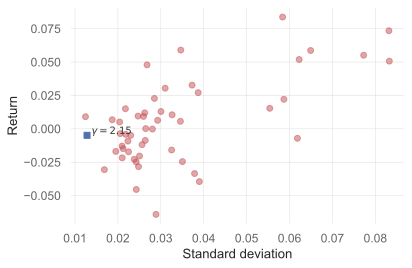

In [35]:
# We can try different gamma value
# It turns out that the constraint is so tough, most gamma remain at the same place
SAMPLES = 10
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-3, 3, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve(solver="ECOS")
    risk_data[i] = cp.sqrt(risk).value
    ret_data[i] = ret.value

fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(50):
    plt.plot(cp.sqrt(Sigma[i,i]).value, mu[i], 'ro', alpha=0.5)

marker = 5
plt.plot(risk_data[marker], ret_data[marker], 'bs')
ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+.001, ret_data[marker]+.001))

plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

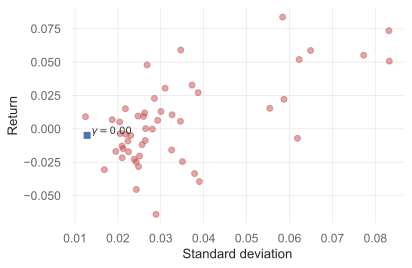

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(50):
    plt.plot(cp.sqrt(Sigma[i,i]).value, mu[i], 'ro', alpha=0.5)

marker = 1
plt.plot(risk_data[marker], ret_data[marker], 'bs')
ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+.001, ret_data[marker]+.001))

plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()